In [33]:
import numpy as np
import torch
from utility import predict_func_2input, load_best_model
from smalltransformer import SmallTransformer
from linear_process import preprocess_pro
from utility import cal_flux, predict_spectra
from sklearn.metrics import r2_score, mean_squared_error
import pickle
from sklearn.cluster import KMeans

In [34]:
# Model
batch_size = 1
model = SmallTransformer().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# model, optimizer, best_val_loss, target_min, target_max = load_best_model(
#     model, optimizer,
#     '/kaggle/input/noisereduction/pytorch/default/1/best_model_NR_v2.0.pth')
model, optimizer, best_val_loss, target_min, target_max = load_best_model(
    model, optimizer, '/kaggle/best_model_ST_v3.3.pth')

Best model loaded.


In [35]:
# 特征
with open('/kaggle/input/train_preprocessed.pkl', 'rb') as file:
    full_predictions_spectra = pickle.load(file)
full_whitelight_s_train = np.array([
    predict_spectra(full_predictions_spectra[i])
    for i in range(len(full_predictions_spectra))
])  # 预测每个星球的白光缩放比例S
full_light_alpha_train = np.array([
    cal_flux(full_predictions_spectra[i])
    for i in range(len(full_predictions_spectra))
])  # 计算每个星球的各个波段的吸收峰相对面积

In [36]:
# 目标
train_solution = np.loadtxt(
    '/kaggle/input/ariel-data-challenge-2024/train_labels.csv',
    delimiter=',',
    skiprows=1)
targets = train_solution[:, 1:]
newtarget = targets / full_whitelight_s_train[:, np.newaxis]
targets_tensor = torch.tensor(newtarget).float()
target_min = targets_tensor.min()
target_max = targets_tensor.max()
full_targets_normalized = (targets_tensor - target_min) / (target_max -
                                                           target_min)

In [37]:
predictions_spectra_test = full_predictions_spectra
min_values = predictions_spectra_test.min(axis=(1, 2), keepdims=True)
max_values = predictions_spectra_test.max(axis=(1, 2), keepdims=True)
normalized_spectra = (predictions_spectra_test - min_values) / (max_values -
                                                                min_values)
data_test_reshaped = torch.tensor(normalized_spectra).float()

In [38]:
whitelight_s_test = full_whitelight_s_train
light_alpha_test = full_light_alpha_train
whitelight_s_test_expanded = np.expand_dims(full_whitelight_s_train * 100,
                                            axis=1)
combined_array = np.concatenate((light_alpha_test, whitelight_s_test_expanded),
                                axis=1)
light_alpha_test = torch.tensor(combined_array).float()

In [39]:
all_predictions = predict_func_2input(model,
                                      data_test_reshaped,
                                      light_alpha_test,
                                      batch_size=1)
all_predictions = all_predictions * (target_max - target_min) + target_min
all_predictions = all_predictions.numpy()

In [40]:
all_predictions.min(), all_predictions.max()

(0.6621059, 1.9849482)

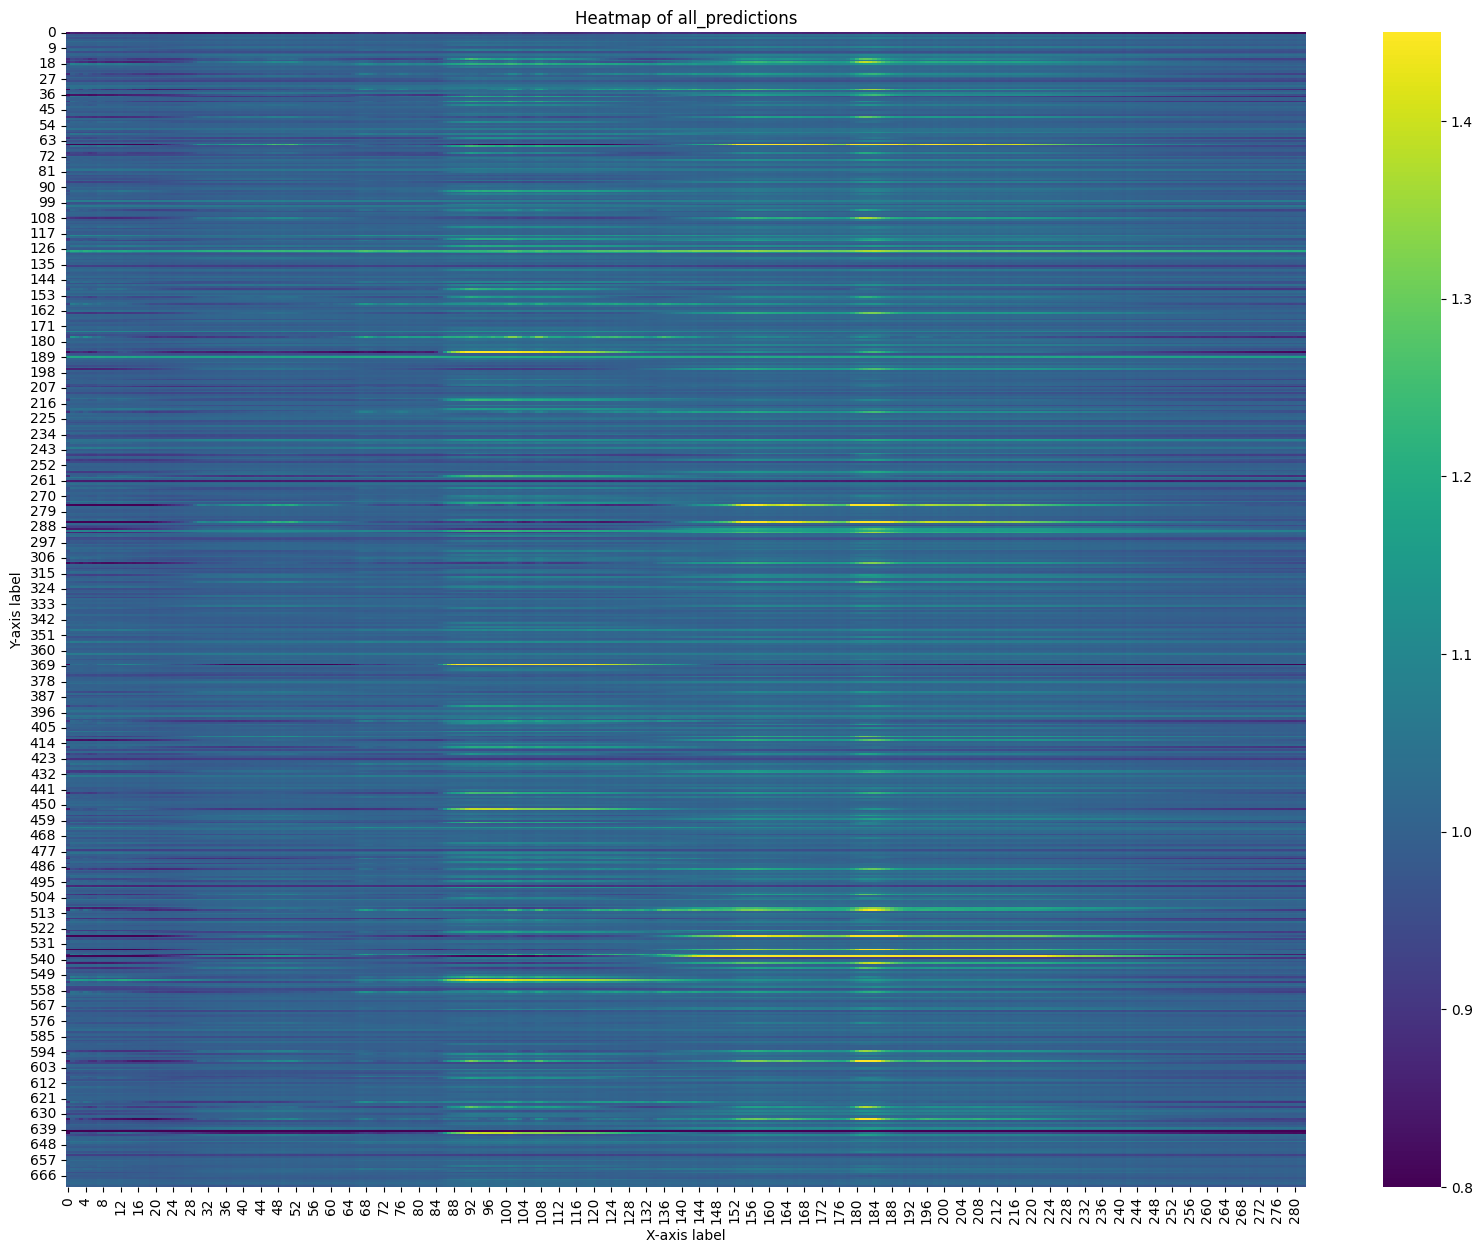

In [41]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形大小
plt.figure(figsize=(20, 15))

# 绘制热力图
sns.heatmap(all_predictions,
            annot=False,
            fmt=".2f",
            cmap="viridis",
            cbar=True,
            vmin=0.8,
            vmax=1.45)

plt.title("Heatmap of all_predictions")
plt.xlabel("X-axis label")
plt.ylabel("Y-axis label")
plt.show()

In [42]:
from utility import postprocessing, competition_score
import pandas as pd

wavelengths = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/wavelengths.csv')
test_adc_info = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
    index_col='planet_id')
train_labels = pd.read_csv(
    '/kaggle/input/ariel-data-challenge-2024/train_labels.csv',
    index_col='planet_id')

In [43]:
reviewtarget = targets / whitelight_s_test[:, np.newaxis]

In [44]:
reviewtarget.min(), reviewtarget.max()

(0.6369762883252131, 1.9870487053280481)

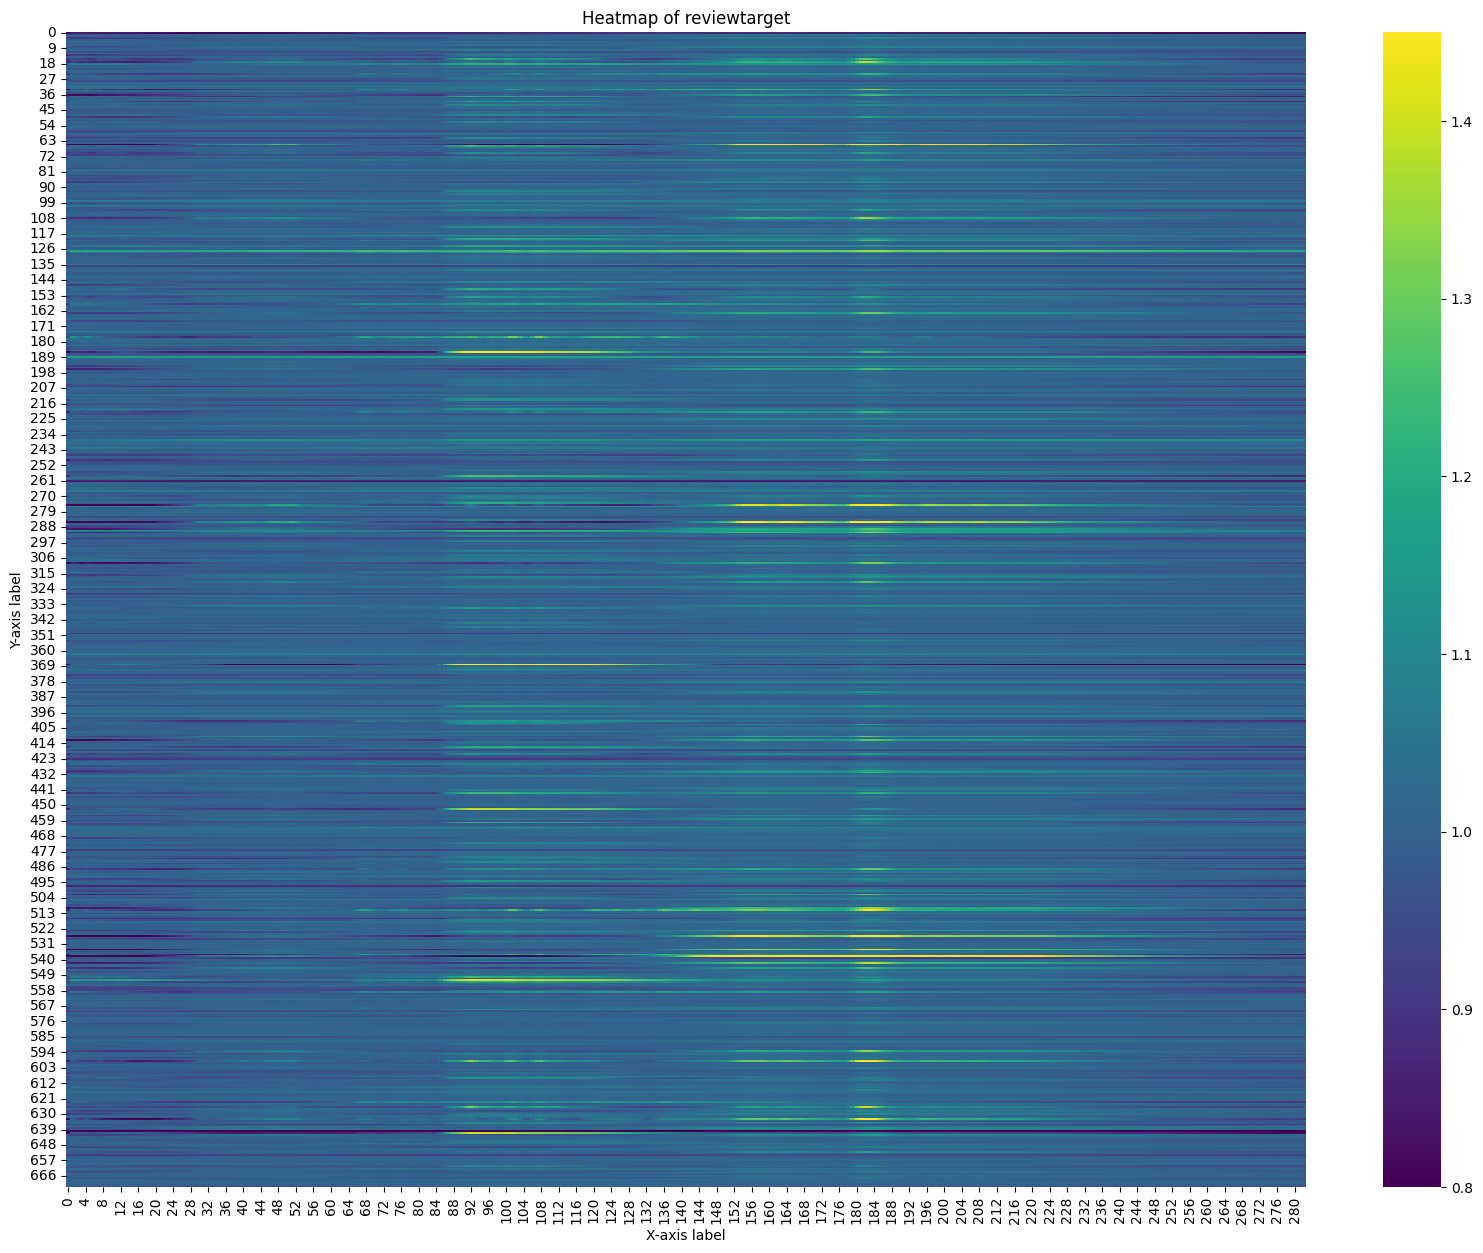

In [45]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形大小
plt.figure(figsize=(20, 15))

# 绘制热力图
sns.heatmap(reviewtarget,
            annot=False,
            fmt=".2f",
            cmap="viridis",
            cbar=True,
            vmin=0.8,
            vmax=1.45)

plt.title("Heatmap of reviewtarget")
plt.xlabel("X-axis label")
plt.ylabel("Y-axis label")
plt.show()

In [46]:
reviewtarget.min(), reviewtarget.max()

(0.6369762883252131, 1.9870487053280481)

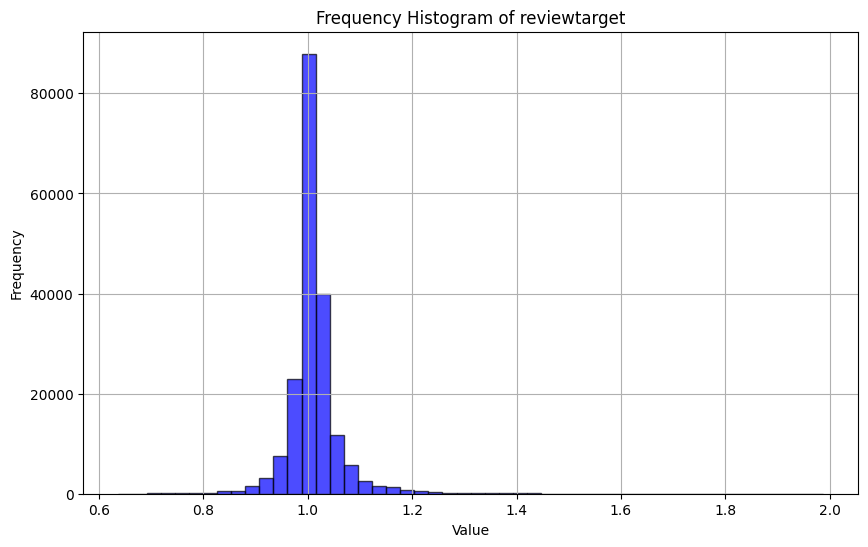

In [47]:
reviewtarget_flat = reviewtarget.flatten()
plt.figure(figsize=(10, 6))
plt.hist(reviewtarget_flat,
         bins=50,
         color='blue',
         edgecolor='black',
         alpha=0.7)
plt.title("Frequency Histogram of reviewtarget")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [48]:
all_predictions = all_predictions * whitelight_s_test[:, np.newaxis]

In [49]:
print(f"# R2 score: {r2_score(targets, all_predictions):.6f}")
sigma_pred = mean_squared_error(targets, all_predictions, squared=False)
print(f"# Root mean squared error: {sigma_pred:.6f}")

# R2 score: 0.999616
# Root mean squared error: 0.000034


In [60]:
# import numpy as np

# waveinfo = all_predictions / whitelight_s_test[:, np.newaxis]
# avg_waveinfo = np.mean(waveinfo, axis=0)
# # 计算两个数组之间的差值
# differences = np.abs(targets - all_predictions
#                      ) / whitelight_s_test[:, np.newaxis] / avg_waveinfo[
#                          np.newaxis, :]

# # 找出差值中的最大值
# max_difference = np.max(differences)

# # 找出最大值所在的行和列
# max_index = np.unravel_index(np.argmax(differences), differences.shape)

# print("Max difference:", max_difference)
# print("Max difference location (row, column):", max_index)
# newsigma = max_difference * whitelight_s_test[:, np.newaxis] * avg_waveinfo[
#     np.newaxis, :]

Max difference: 0.13131724977418643
Max difference location (row, column): (13, 0)


In [64]:
import numpy as np

waveinfo = all_predictions / whitelight_s_test[:, np.newaxis]
avg_waveinfo = np.mean(waveinfo, axis=0)
# 计算两个数组之间的差值
differences = np.abs(targets - all_predictions)

# 找出差值中的最大值
max_difference = np.max(differences)

# 找出最大值所在的行和列
max_index = np.unravel_index(np.argmax(differences), differences.shape)
std_size = max_difference / whitelight_s_test[max_index[0]] / avg_waveinfo[
    max_index[1]]
print("Max difference:", max_difference)
print("Max difference location (row, column):", max_index)
newsigma = std_size * whitelight_s_test[:, np.newaxis] * avg_waveinfo[
    np.newaxis, :]

Max difference: 0.00043270393859252704
Max difference location (row, column): (652, 182)


In [65]:
newsigma

array([[0.00012073, 0.00012331, 0.00012296, ..., 0.00012234, 0.00012289,
        0.00012228],
       [0.00016989, 0.00017351, 0.00017302, ..., 0.00017214, 0.00017292,
        0.00017207],
       [0.00024962, 0.00025494, 0.00025422, ..., 0.00025294, 0.00025408,
        0.00025282],
       ...,
       [0.0005885 , 0.00060104, 0.00059933, ..., 0.00059631, 0.00059899,
        0.00059604],
       [0.00051216, 0.00052307, 0.00052158, ..., 0.00051896, 0.00052129,
        0.00051873],
       [0.00014089, 0.0001439 , 0.00014349, ..., 0.00014276, 0.00014341,
        0.0001427 ]])

In [52]:
import pickle

savedict = {"std_size": std_size, "avg_waveinfo": avg_waveinfo}
with open('newsigmadict.pkl', 'wb') as f:
    pickle.dump(savedict, f)

In [ ]:
with open('newsigmadict.pkl', 'rb') as f:
    newsigmadict = pickle.load(f)
std_size = newsigmadict["std_size"]
avg_waveinfo = newsigmadict["avg_waveinfo"]
newsigma = std_size * whitelight_s_test[:, np.newaxis] * avg_waveinfo[
    np.newaxis, :]

In [62]:
sub_df = postprocessing(all_predictions,
                        wavelengths,
                        test_adc_info.index,
                        sigma_pred=newsigma)

In [63]:
gll_score = competition_score(train_labels.copy().reset_index(),
                              sub_df.copy().reset_index(),
                              naive_mean=train_labels.values.mean(),
                              naive_sigma=train_labels.values.std(),
                              sigma_true=0.00001)
print(f"# Estimated competition score: {gll_score:.3f}")

# Estimated competition score: 0.418
